In [1]:
#notebook setup
import os
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

#get current working directory 
cwd = os.getcwd()

#get data
file_path = os.path.join(cwd, 'Dataset', 'seq_temp.csv')

In [2]:
def import_prep_data(path, load_columns):
    
    #load data with specific columns
    seq_temp = pd.read_csv(path, usecols=load_columns)
    
    #drop na values
    seq_temp.dropna(subset=['pH', 'Sequence', 'Tm_(C)'], inplace=True)
    
    #trim Tm_(C) and convert to float
    for i in seq_temp.index:
        if '(' in seq_temp.loc[i, 'Tm_(C)'][:4]:
            seq_temp.loc[i, 'Tm_(C)'] = seq_temp.loc[i, 'Tm_(C)'][:2]
        else:
            seq_temp.loc[i, 'Tm_(C)'] = seq_temp.loc[i, 'Tm_(C)'][:4]
    seq_temp['Tm_(C)'] = seq_temp['Tm_(C)'].astype(float)
    
    return seq_temp

In [3]:
temp = import_prep_data(file_path, ['UniProt_ID', 'pH', 'Tm_(C)', 'Sequence', 'Sequence_length' ])
display(temp.info(), temp.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4743 entries, 0 to 4777
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UniProt_ID       4743 non-null   object 
 1   pH               4743 non-null   float64
 2   Tm_(C)           4743 non-null   float64
 3   Sequence         4743 non-null   object 
 4   Sequence_length  4743 non-null   float64
dtypes: float64(3), object(2)
memory usage: 351.4+ KB


None

,UniProt_ID,pH,Tm_(C),Sequence,Sequence_length
0,P19515,8.0,58.7,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,363.0
1,P43080,7.5,49.8,MGNVMEGKSVEELSSTECHQWYKKFMTECPSGQLTLYEFRQFFGLK...,201.0
2,P43080,7.5,50.3,MGNVMEGKSVEELSSTECHQWYKKFMTECPSGQLTLYEFRQFFGLK...,201.0
3,P31513,7.4,45.8,MGKKVAIIGAGVSGLASIRSCLEEGLEPTCFEKSNDIGGLWKFSDH...,532.0
4,P31513,7.4,50.6,MGKKVAIIGAGVSGLASIRSCLEEGLEPTCFEKSNDIGGLWKFSDH...,532.0


In [4]:
def trim_data(frame, ph_upper, ph_lower, seq_len_upper, seq_len_lower):
    '''
    Function to make trim the DataFrame
    based on upper and lower limits for 
    pH values and sequence lengths. 
    '''
    ph_trim = frame[(frame['pH'] >= ph_lower) & (frame['pH'] <= ph_upper)]
    ph_seq_trim = ph_trim[(ph_trim['Sequence_length'] >= seq_len_lower) & (ph_trim['Sequence_length'] <= seq_len_upper)]
    
    return ph_seq_trim

In [5]:
'''
pH is known to influence Tm. Tm
range was selected based on prior
exploration that showed the largest
sample size within 1 pH unit was 
between pH 6 and 7.
'''
trim_temp = trim_data(temp, 7, 6, 500, 100)
display(trim_temp.info(), trim_temp.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1118 entries, 27 to 4773
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UniProt_ID       1118 non-null   object 
 1   pH               1118 non-null   float64
 2   Tm_(C)           1118 non-null   float64
 3   Sequence         1118 non-null   object 
 4   Sequence_length  1118 non-null   float64
dtypes: float64(3), object(2)
memory usage: 52.4+ KB


None

,UniProt_ID,pH,Tm_(C),Sequence,Sequence_length
27,P17989,7.0,48.0,MNIKKTAVKSALAVAAAAAALTTNVSAKDFSGAELYTLEEVQYGKF...,349.0
28,P62593,6.8,51.5,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,286.0
29,P0ABE7,6.0,54.0,MRKSLLAILAVSSLVFSSASFAADLEDNMETLNDNLKVIEKADNAA...,128.0
34,P02699,7.0,55.8,MNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFL...,348.0
38,P00651,6.0,57.2,MMYSKLLTLTTLLLPTALALPSLVERACDYTCGSNCYSSSDVSTAQ...,130.0


In [6]:
#create classes
temp_bins = [0, 40, 50, 100]
temp_labels = ['0', '1', '2'] #high risk (0), low_risk (1), target (2)

temp_cat = pd.cut(trim_temp['Tm_(C)'], temp_bins, labels=temp_labels)

trim_temp['cat'] = temp_cat
display(trim_temp.info(), trim_temp.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1118 entries, 27 to 4773
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   UniProt_ID       1118 non-null   object  
 1   pH               1118 non-null   float64 
 2   Tm_(C)           1118 non-null   float64 
 3   Sequence         1118 non-null   object  
 4   Sequence_length  1118 non-null   float64 
 5   cat              1118 non-null   category
dtypes: category(1), float64(3), object(2)
memory usage: 53.6+ KB


None

,UniProt_ID,pH,Tm_(C),Sequence,Sequence_length,cat
27,P17989,7.0,48.0,MNIKKTAVKSALAVAAAAAALTTNVSAKDFSGAELYTLEEVQYGKF...,349.0,1
28,P62593,6.8,51.5,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,286.0,2
29,P0ABE7,6.0,54.0,MRKSLLAILAVSSLVFSSASFAADLEDNMETLNDNLKVIEKADNAA...,128.0,2
34,P02699,7.0,55.8,MNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFL...,348.0,2
38,P00651,6.0,57.2,MMYSKLLTLTTLLLPTALALPSLVERACDYTCGSNCYSSSDVSTAQ...,130.0,2


<AxesSubplot:>

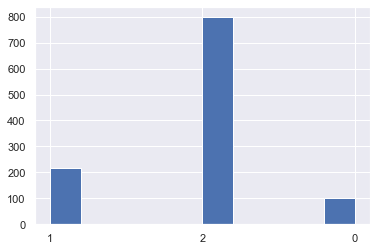

In [7]:
'''
Example the distribtion of Tm categories. 
'''
trim_temp['cat'].hist()

In [8]:
'''
Tm in the no risk category are over
represented. Risk categories are going
to be evenly selected for equal 
representation in the training and 
test set
'''
#break data into parts 
high_risk_temp = trim_temp[trim_temp['cat'] == '0']
risk_temp = trim_temp[trim_temp['cat'] == '1']
target_temp = trim_temp[trim_temp['cat'] == '2']

equal_temp = pd.concat([high_risk_temp[:100], risk_temp[:100],
                       target_temp[:100]])
display(equal_temp.info(), equal_temp.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 70 to 282
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   UniProt_ID       300 non-null    object  
 1   pH               300 non-null    float64 
 2   Tm_(C)           300 non-null    float64 
 3   Sequence         300 non-null    object  
 4   Sequence_length  300 non-null    float64 
 5   cat              300 non-null    category
dtypes: category(1), float64(3), object(2)
memory usage: 14.5+ KB


None

,UniProt_ID,pH,Tm_(C),Sequence,Sequence_length,cat
70,P00711,7.0,25.0,MMSFVSLLLVGILFHATQAEQLTKCEVFRELKDLKGYGGVSLPEWV...,142.0,0
104,P11376,6.0,37.0,KVFSKCELAHKLKAQEMDGFGGYSLANWVCMAEYESNFNTRAFNGK...,129.0,0
326,P05230,6.6,40.0,MAEGEITTFTALTEKFNLPPGNYKKPKLLYCSNGGHFLRILPDGTV...,155.0,0
329,P38584,7.0,25.9,MYTFVVRDENSSVYAEVSRLLLATGHWKRLRRDNPRFNLMLGERNR...,377.0,0
330,P38584,7.0,25.9,MYTFVVRDENSSVYAEVSRLLLATGHWKRLRRDNPRFNLMLGERNR...,377.0,0


In [9]:
#MNB requires list input create function to generate lists 
def frame_to_list(frame, y_frame, x_frame):
    '''
    y_frame is column from dataframe to be
    used as labels. No transformation needed.
    simply convert to numpy array
    
    x_frame is column from DataFrame to be
    converted to a list. sequence of amino
    acids need to be convert to string with
    spacing between.
    '''
    #convert labels into numpy array
    labels = frame[y_frame].to_numpy()
    
    seq_list = []
    
    for row in frame.index:
        seq_to_split = frame.loc[row, x_frame]
        seq_list.append(' '.join(seq_to_split))
        
    return seq_list, labels 

In [10]:
'''
Ensure features matrix and labels are
in the correct format for MNB
'''
X, y = frame_to_list(equal_temp, 'cat', 'Sequence')
print(X[2], type(X[2]))
y[2], type(X), type(y)

M A E G E I T T F T A L T E K F N L P P G N Y K K P K L L Y C S N G G H F L R I L P D G T V D G T R D R S D Q H I Q L Q L S A E S V G E V Y I K S T E T G Q Y L A M D T D G L L Y G S Q T P N E E C L F L E R L E E N H Y N T Y I S K K H A E K N W F V G L K K N G S C K R G P R T H Y G Q K A I L F L P L P V S S D <class 'str'>


('0', list, numpy.ndarray)

In [11]:
#make pipeline, train. predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

'''
TfidfVectorizer ignores single character
words. Use tokenizer parameter to adjust
for single characters.
'''

model = make_pipeline(TfidfVectorizer(tokenizer=lambda txt: txt.split()), MultinomialNB())

#train
model.fit(X, y)
labels = model.predict(X)

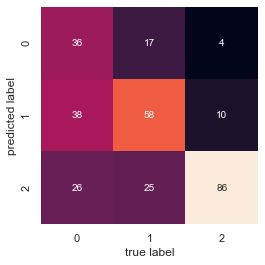

In [12]:
#confusion matrix between true and predicted labels 
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y, labels)

#plot confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=temp_labels, yticklabels=temp_labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
'''
Given no current methods for selecting
against Tm of high risk, this is reasonable.
Try a more powerful algorithm to see if
classification can be improved
'''

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

param_grid = {'svc__C': [0.0001, 0.001, 0.1, 1, 1E1, 1E2],
         'svc__gamma': [0.01, 0.1, 1, 1E1, 1E2, 1E3, 1E4, 1E5, 1E6]}

vec = TfidfVectorizer(tokenizer=lambda txt: txt.split())
svc = SVC()

model = make_pipeline(vec, svc)

grid = GridSearchCV(model, param_grid, cv=7)
grid.fit(X, y)
print(grid.best_params_)

model = grid.best_estimator_

{'svc__C': 10.0, 'svc__gamma': 1}


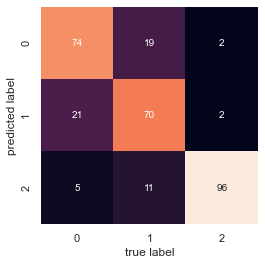

In [14]:
y_pred = model.predict(X)
matx = confusion_matrix(y, y_pred)

#plot confusion matrix
sns.heatmap(matx.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=temp_labels, yticklabels=temp_labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

0.8

In [ ]:
'''
Positive results. Properly split
data into training and test set
'''

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {'svc__C': [0.0001, 0.001, 0.1, 1, 1E1, 1E2],
         'svc__gamma': [0.01, 0.1, 1, 1E1, 1E2, 1E3, 1E4, 1E5, 1E6]}

vec = TfidfVectorizer(tokenizer=lambda txt: txt.split())
svc = SVC()

model = make_pipeline(vec, svc)

grid = GridSearchCV(model, param_grid, cv=7)
grid.fit(X_train, y_train)
print(grid.best_params_)

model = grid.best_estimator_

{'svc__C': 100.0, 'svc__gamma': 1}


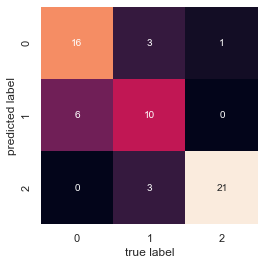

In [17]:
y_pred = model.predict(X_test)
matx = confusion_matrix(y_test, y_pred)

#plot confusion matrix
sns.heatmap(matx.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=temp_labels, yticklabels=temp_labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7833333333333333

In [19]:
#check for overfitting
y_self = model.predict(X_train)
accuracy_score(y_train, y_self)

0.825